In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import normalize


import os
import pathlib
import sys
import matplotlib.pyplot as plt
from scipy import linalg


sys.path.append(os.path.join(pathlib.Path(os.getcwd()).parent))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from utils.bq_conn import bq_conn_file
# %%
bq_client = bq_conn_file(project_id="dsa-miad-365616")

In [2]:
pd.options.display.max_columns = None

query = '''
SELECT
    *
FROM `Proyecto.DatosSecopI`
ORDER BY anno_cargue_secop DESC
'''
bq_client = bq_conn_file(project_id="dsa-miad-365616")
secop_I = bq_client.execute_query(query=query)
#print(f"El número de filas del dataset: {secop_I.shape[0]}\nEl número de columnas del dataset: {secop_I.shape[1]}")
secop_I.head(5)
secop_I.columns




Index(['uid', 'anno_cargue_secop', 'id_modalidad', 'modalidad_de_contratacion',
       'estado_del_proceso', 'id_objeto_a_contratar',
       'detalle_del_objeto_a_contratar', 'tipo_de_contrato',
       'municipio_de_obtencion', 'municipios_ejecucion_',
       'departamento_ejecucion', 'numero_de_proceso', 'numero_de_contrato',
       'cuantia_proceso', 'id_grupo', 'nombre_grupo', 'id_familia',
       'nombre_familia', 'id_clase', 'nombre_clase', 'id_adjudicacion',
       'tipo_identifi_del_contratista', 'identificacion_del_contratista',
       'nom_razon_social_contratista', 'tipo_doc_representante_legal',
       'identific_representante_legal', 'plazo_de_ejec_del_contrato_',
       'dias_ejec_final_contrato', 'rango_de_ejec_del_contrato', 'prorrogado',
       'tiempo_adiciones_en_dias', 'cuantia_contrato', 'con_adicion_pptal',
       'valor_total_de_adiciones', 'valor_contrato_con_adiciones', 'moneda',
       'objeto_del_contrato_a_la', 'ruta_proceso_en_secop_i'],
      dtype='object'

In [3]:
secopI_filter = secop_I[
    ['id_modalidad', 'id_objeto_a_contratar', 'detalle_del_objeto_a_contratar','tipo_de_contrato', 'departamento_ejecucion', 'id_grupo','id_clase', 'id_familia',
     'dias_ejec_final_contrato', 'tiempo_adiciones_en_dias', 'valor_total_de_adiciones']]

secopI_filter
secopI_filter.columns
base = secopI_filter
n = base.isna() == True
base = base.fillna(0)
base.info()
print(base)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26553 entries, 0 to 26552
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   id_modalidad                    26553 non-null  Int64 
 1   id_objeto_a_contratar           26553 non-null  Int64 
 2   detalle_del_objeto_a_contratar  26553 non-null  object
 3   tipo_de_contrato                26553 non-null  object
 4   departamento_ejecucion          26553 non-null  object
 5   id_grupo                        26553 non-null  object
 6   id_clase                        26553 non-null  object
 7   id_familia                      26553 non-null  object
 8   dias_ejec_final_contrato        26553 non-null  Int64 
 9   tiempo_adiciones_en_dias        26553 non-null  Int64 
 10  valor_total_de_adiciones        26553 non-null  Int64 
dtypes: Int64(5), object(6)
memory usage: 2.4+ MB
       id_modalidad  id_objeto_a_contratar   
0              

In [4]:
# Codificación de las variables categoricas
base['tipo_de_contrato'] = pd.factorize(base.tipo_de_contrato)[0]
base['departamento_ejecucion'] = pd.factorize(base.departamento_ejecucion)[0]
base['detalle_del_objeto_a_contratar'] = pd.factorize(base.detalle_del_objeto_a_contratar)[0]
base['id_grupo'] = pd.factorize(base.id_grupo)[0]
base['id_familia'] = pd.factorize(base.id_familia)[0]
base['id_clase'] = pd.factorize(base.id_clase)[0]

In [5]:
df = base
df.columns

Index(['id_modalidad', 'id_objeto_a_contratar',
       'detalle_del_objeto_a_contratar', 'tipo_de_contrato',
       'departamento_ejecucion', 'id_grupo', 'id_clase', 'id_familia',
       'dias_ejec_final_contrato', 'tiempo_adiciones_en_dias',
       'valor_total_de_adiciones'],
      dtype='object')

<Axes: >

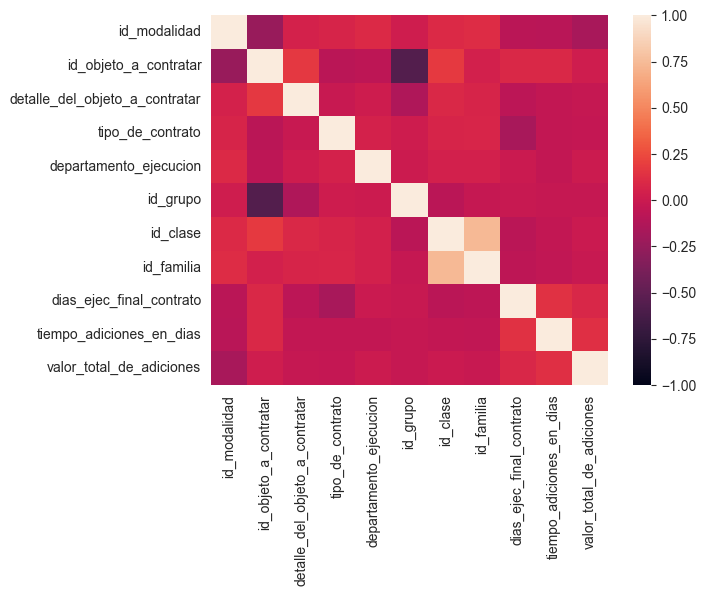

In [6]:
import seaborn as sns
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=False)


In [7]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)


train_X = train_dataset.drop(['valor_total_de_adiciones'], axis=1)
test_X = test_dataset.drop(['valor_total_de_adiciones'], axis=1)

In [8]:
train_stats = train_X.describe()
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
id_modalidad,21242.0,12.850909,0.537507,1.0,13.0,13.0,13.0,19.0
id_objeto_a_contratar,21242.0,47790603.521326,19854229.145802,10000000.0,44000000.0,50000000.0,53000000.0,95000000.0
detalle_del_objeto_a_contratar,21242.0,9487.725355,5694.88157,0.0,4489.0,9377.5,14204.0,20039.0
tipo_de_contrato,21242.0,2.136098,2.327779,0.0,0.0,1.0,5.0,9.0
departamento_ejecucion,21242.0,8.671924,6.699319,0.0,3.0,8.0,12.0,30.0
id_grupo,21242.0,1.139488,1.814365,0.0,0.0,0.0,1.0,6.0
id_clase,21242.0,205.27987,205.354927,0.0,63.0,89.0,378.0,958.0
id_familia,21242.0,75.602486,63.051993,0.0,37.0,50.0,92.0,299.0
dias_ejec_final_contrato,21242.0,80.745645,144.756015,0.0,15.0,30.0,100.0,7500.0
tiempo_adiciones_en_dias,21242.0,1.224696,9.859468,0.0,0.0,0.0,0.0,230.0


In [9]:
train_labels = train_dataset.pop('valor_total_de_adiciones')
test_labels = test_dataset.pop('valor_total_de_adiciones')

In [10]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [11]:
[len(train_dataset.keys())]

[10]

In [12]:
def build_model ():
  model = keras.Sequential([
    layers.Dense(10, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='relu'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [13]:
model = build_model()

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 8)                 88        
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 239 (956.00 Byte)
Trainable params: 239 (956.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
train_data = np.asarray(normed_train_data).astype(np.float32)
test_data = np.asarray(normed_test_data).astype(np.float32)


In [16]:
example_batch = train_data[:]
example_result = model.predict(example_batch)
example_result

664/664 [==============================] - 0s 369us/step


array([[-0.3009733 ],
       [-0.27146947],
       [-0.33289665],
       ...,
       [-0.07353059],
       [-0.14637645],
       [-0.47097412]], dtype=float32)

In [17]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 100

from keras import backend as K
train_data = K.cast_to_floatx(train_data)
train_labels = K.cast_to_floatx(train_labels)

history = model.fit(
  train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist)

            loss           mae           mse      val_loss      val_mae   
0   3.970696e+13  7.060656e+05  3.970696e+13  2.710808e+14  1139867.375  \
1   3.970694e+13  7.060699e+05  3.970694e+13  2.710808e+14  1139874.000   
2   3.970692e+13  7.060816e+05  3.970692e+13  2.710807e+14  1139889.625   
3   3.970680e+13  7.061072e+05  3.970680e+13  2.710805e+14  1139927.125   
4   3.970654e+13  7.061675e+05  3.970654e+13  2.710799e+14  1140003.250   
..           ...           ...           ...           ...          ...   
95  3.747858e+13  1.117835e+06  3.747858e+13  2.667660e+14  1517807.250   
96  3.747044e+13  1.116158e+06  3.747044e+13  2.667448e+14  1518239.125   
97  3.746380e+13  1.117352e+06  3.746380e+13  2.667254e+14  1518486.875   
98  3.745664e+13  1.117093e+06  3.745664e+13  2.667091e+14  1517785.875   
99  3.745051e+13  1.116694e+06  3.745051e+13  2.666888e+14  1518219.000   

         val_mse  epoch  
0   2.710808e+14      0  
1   2.710808e+14      1  
2   2.710807e+14     

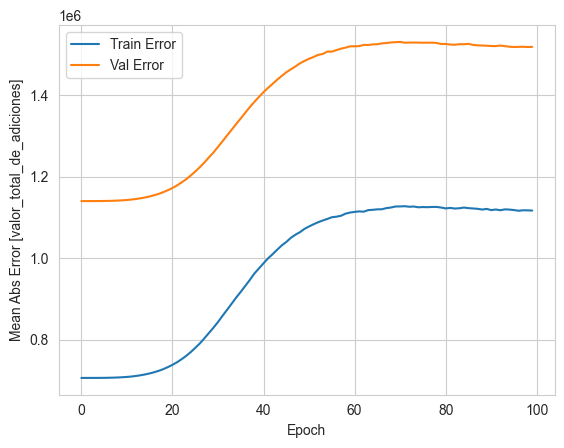

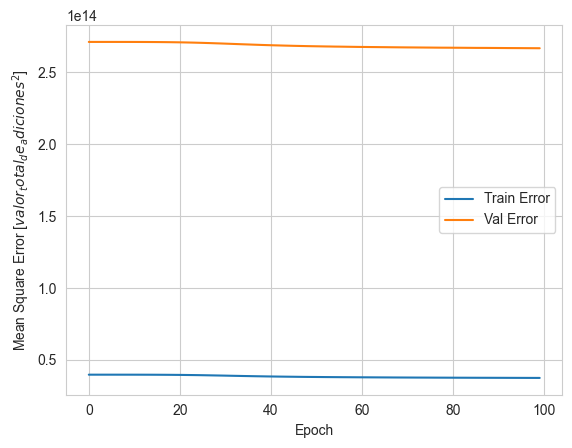

In [19]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [valor_total_de_adiciones]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$valor_total_de_adiciones^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()


plot_history(history)

In [20]:
model_imp = build_model()

In [21]:
test_data = np.asarray(normed_test_data).astype(np.float32)
example_result = model_imp.predict(np.array(test_data[:]))
resultados = pd.DataFrame(example_result)
resultados.columns = ['resultados']
print(resultados)

166/166 [==============================] - 0s 367us/step
      resultados
0      -0.004155
1      -0.004178
2      -0.003984
3      -0.003981
4      -0.003977
...          ...
5306    0.000000
5307    0.028124
5308    0.032756
5309    0.038113
5310    0.092895

[5311 rows x 1 columns]


In [22]:
test_data = np.asarray(normed_test_data).astype(np.float32)

In [23]:
test_labels = pd.DataFrame(test_labels)
compare = pd.concat([resultados, test_labels], axis=1)
compare = compare.fillna(0)

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse_t = mean_squared_error(compare['resultados'], compare['valor_total_de_adiciones'])
mae_t = mean_absolute_error(compare['resultados'], compare['valor_total_de_adiciones'])
print("El MSE entre las columnas 'Modelo' y 'Dato' es:", mse_t)
print("El MAE entre las columnas 'Modelo' y 'Dato' es:", mae_t)


El MSE entre las columnas 'Modelo' y 'Dato' es: 29993952647999.027
El MAE entre las columnas 'Modelo' y 'Dato' es: 398013.2052726858


In [25]:
weights = model.get_weights()[0]
biases = model.get_weights()[1]

# Imprimir los coeficientes
print("Coeficientes (m):")
for i, w in enumerate(weights):
    print(f"m{i+1}: {w[0]}")

print("")

# Imprimir el sesgo (intercepto) (B)
print("Sesgo (B):")
print(biases[0])

Coeficientes (m):
m1: -4.363020896911621
m2: -3.3603365421295166
m3: -3.0854079723358154
m4: -4.0151448249816895
m5: -1.7453696727752686
m6: -6.761050701141357
m7: 0.23614056408405304
m8: 0.3070361018180847
m9: 8.544408798217773
m10: 9.259669303894043

Sesgo (B):
5.968058
